In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
tf.enable_eager_execution()
import importlib
import os

from matplotlib import pyplot as plt
%matplotlib notebook

from transliteration import data, train, model_one, script, decode, evaluate

In [2]:
importlib.reload(data)
batch_size = 128
cmu_train_dataset = data.make_dataset('../data/tfrecord/cmu_train.tfrecord',
                                      from_script='en',
                                      to_script='cmu',
                                      combine_words_proportion=0.3,
                                      batch_size=batch_size)
cmu_valid_dataset = data.make_dataset('../data/tfrecord/cmu_valid.tfrecord',
                                      from_script='en',
                                      to_script='cmu',
                                      combine_words_proportion=0.3,
                                      batch_size=batch_size)
cmu_test_dataset = data.make_dataset('../data/tfrecord/cmu_test.tfrecord',
                                     from_script='en',
                                     to_script='cmu',
                                     combine_words_proportion=0.3,
                                     batch_size=batch_size)
eob_train_dataset = data.make_dataset('../data/tfrecord/eob_train.tfrecord',
                                      from_script='en',
                                      to_script='ja',
                                      batch_size=batch_size)
eob_valid_dataset = data.make_dataset('../data/tfrecord/eob_valid.tfrecord',
                                      from_script='en',
                                      to_script='ja',
                                      batch_size=batch_size)
eob_test_dataset = data.make_dataset('../data/tfrecord/eob_test.tfrecord',
                                     from_script='en',
                                     to_script='ja',
                                     batch_size=batch_size)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
optimizer = tf.train.AdamOptimizer()

# def loss_function(real, pred):
#     mask = 1 - np.equal(real, 0)
#     loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred)
#     return tf.reduce_mean(loss_ * mask)

encoder_config = model_one.Config(lstm_size=480,
                                  embedding_size=30,
                                  attention_size=None,
                                  vocab_size=script.SCRIPTS['en'].vocab_size)
ja_decoder_config = model_one.Config(lstm_size=240,
                                     embedding_size=30,
                                     attention_size=120,
                                     # attention='monotonic_bahdanau',
                                     vocab_size=script.SCRIPTS['ja'].vocab_size)
cmu_decoder_config = model_one.Config(lstm_size=480,
                                      embedding_size=30,
                                      attention_size=240,
                                      # attention='monotonic_bahdanau',
                                      vocab_size=script.SCRIPTS['cmu'].vocab_size)
encoder = model_one.Encoder(encoder_config)
ja_decoder = model_one.Decoder(ja_decoder_config)
cmu_decoder = model_one.Decoder(cmu_decoder_config)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
def make_checkpoint_obj():
    return tf.train.Checkpoint(optimizer=optimizer,
                               encoder=encoder,
                               ja_decoder=ja_decoder,
                               cmu_decoder=cmu_decoder)

In [4]:
cmu_best_val_loss = None
cmu_checkpoint = None
checkpoint_obj = None

In [5]:
for e in range(15):
    loss = train.run_one_epoch(cmu_train_dataset,
                               True,
                               from_script='en',
                               to_script='cmu',
                               encoder=encoder,
                               decoder=cmu_decoder,
                               optimizer=optimizer,
                               loss_function=model_one.loss_function)
    valid_loss = train.run_one_epoch(cmu_valid_dataset,
                                     False,
                                     from_script='en',
                                     to_script='cmu',
                                     encoder=encoder,
                                     decoder=cmu_decoder,
                                     loss_function=model_one.loss_function)
    if checkpoint_obj is None:
        checkpoint_obj = make_checkpoint_obj()
    if cmu_best_val_loss is None or valid_loss < cmu_best_val_loss:
        cmu_best_val_loss = valid_loss
        cmu_checkpoint = checkpoint_obj.save(file_prefix=checkpoint_prefix)
    print("Epoch {}: Train Loss {:.3f}, Valid Loss {:.3f}".format(e, loss, valid_loss))
    print(decode.transliterate(input_strs=['derick'],
                               from_script='en',
                               to_script='cmu',
                               encoder=encoder,
                               decoder=cmu_decoder,
                               k_best=2,
                               decoding_method=decode.beam_search_decode))

Epoch 0: Train Loss 2.142, Valid Loss 0.933


([['D EH1 R IH0 K K IH0 K', 'D EH1 R IH0 K S']], array([[-5.57163484, -5.62444009]]))


Epoch 1: Train Loss 0.676, Valid Loss 0.585


([['D R IH1 K IH0 NG K AH0 K', 'D EH1 R IH0 K AH0 K']], array([[-5.07599688, -5.5471953 ]]))


Epoch 2: Train Loss 0.480, Valid Loss 0.441


([['D ER0 IH1 K S K ER0 IH0 K', 'D ER0 IH1 K K AH0 L K']], array([[-4.99436543, -5.36274402]]))


Epoch 3: Train Loss 0.407, Valid Loss 0.394


([['D EH1 R IH0 K K IH0 NG', 'D EH1 R IH0 K K IH2 NG K AA2 K R IH0 K K IH1 K IH0 NG']], array([[-5.04901008, -9.70708157]]))


Epoch 4: Train Loss 0.387, Valid Loss 0.379


([['D ER1 IH0 K S K ER0 IH0 K', 'D EH1 R IH0 K S K ER0 IH0 K']], array([[-5.00310572, -5.60679595]]))


KeyboardInterrupt: 

In [7]:
vs = encoder.variables

In [9]:
vs[0].trainable

True

In [9]:
checkpoint_obj.restore(cmu_checkpoint).assert_consumed()
print(train.run_one_epoch(cmu_valid_dataset,
                          False,
                          from_script='en',
                          to_script='cmu',
                          encoder=encoder,
                          decoder=cmu_decoder,
                          loss_function=loss_function))

AttributeError: 'NoneType' object has no attribute 'restore'

In [7]:
ja_checkpoint_path = None
ja_best_val_loss = None

In [8]:
def run_some_epochs(epochs):
    global ja_best_val_loss
    global ja_checkpoint_path
    for e in range(epochs):
        loss = train.run_one_epoch(eob_train_dataset,
                                   True,
                                   from_script='en',
                                   to_script='ja',
                                   encoder=encoder,
                                   decoder=ja_decoder,
                                   optimizer=optimizer,
                                   loss_function=loss_function)
        valid_loss = train.run_one_epoch(eob_valid_dataset,
                                         False,
                                         from_script='en',
                                         to_script='ja',
                                         encoder=encoder,
                                         decoder=ja_decoder,
                                         loss_function=loss_function)
        print("Epoch {}: Train Loss {:.3f}, Valid Loss {:.3f}".format(e, loss, valid_loss))
        print(decode.transliterate(input_strs=['derick'],
                                       from_script='en',
                                       to_script='ja',
                                       encoder=encoder,
                                       decoder=ja_decoder,
                                       k_best=2,
                                       decoding_method=decode.beam_search_decode))
        if ja_best_val_loss is None or valid_loss < ja_best_val_loss:
            ja_best_val_loss = valid_loss
            ja_checkpoint_path = checkpoint.save(file_prefix=checkpoint_prefix)
    return ja_checkpoint_path

In [6]:
for layer in encoder.layers:
    layer.trainable = False

In [9]:
checkpoint_path = run_some_epochs(5)
checkpoint.restore(checkpoint_path).assert_consumed()
train.run_one_epoch(eob_valid_dataset,
                    False,
                    from_script='en',
                    to_script='ja',
                    encoder=encoder,
                    decoder=ja_decoder,
                    loss_function=loss_function)

Epoch 0: Train Loss 14.001, Valid Loss 7.251
([['デリッククク', 'デリックククク']], array([[-4.82425376, -5.83232583]]))


Epoch 1: Train Loss 6.135, Valid Loss 5.481
([['デリックク', 'デリックカク']], array([[-3.54561986, -4.39624394]]))


Epoch 2: Train Loss 4.533, Valid Loss 5.090
([['デリック', 'デリックク']], array([[-1.81304679, -2.34258804]]))


Epoch 3: Train Loss 3.583, Valid Loss 4.614


([['デリックク', 'デリック']], array([[-1.80051493, -2.36706394]]))


Epoch 4: Train Loss 2.898, Valid Loss 4.670
([['デリック', 'デリックク']], array([[-1.82217294, -2.02979601]]))


<tf.Tensor: id=161215225, shape=(), dtype=float32, numpy=4.5198107>

In [10]:
for layer in encoder.layers:
    layer.trainable = True
checkpoint_path = run_some_epochs(10)
checkpoint.restore(checkpoint_path).assert_consumed()
train.run_one_epoch(eob_valid_dataset,
                    False,
                    from_script='en',
                    to_script='ja',
                    encoder=encoder,
                    decoder=ja_decoder,
                    loss_function=loss_function)

Epoch 0: Train Loss 2.870, Valid Loss 4.854


([['デリックク', 'デリック']], array([[-2.26455429, -2.32946178]]))


Epoch 1: Train Loss 2.368, Valid Loss 4.819
([['デリックク', 'デリック']], array([[-1.6791885 , -1.90170635]]))


Epoch 2: Train Loss 1.931, Valid Loss 4.945
([['デリック', 'デリックク']], array([[-1.24727619, -2.21278406]]))


Epoch 3: Train Loss 1.615, Valid Loss 5.004
([['デリック', 'デリックク']], array([[-1.74055413, -1.74162331]]))


Epoch 4: Train Loss 1.278, Valid Loss 5.046
([['デリックク', 'デリック']], array([[-1.47543161, -2.05134993]]))


Epoch 5: Train Loss 1.069, Valid Loss 5.317
([['デリックク', 'デリック']], array([[-1.09070256, -1.77635571]]))


Epoch 6: Train Loss 0.894, Valid Loss 5.284
([['デリックク', 'デリック']], array([[-0.64551125, -1.97105934]]))


Epoch 7: Train Loss 0.792, Valid Loss 5.425
([['デリックク', 'デリッククリック']], array([[-0.59980905, -2.32010709]]))


Epoch 8: Train Loss 0.678, Valid Loss 5.567
([['デリッククリック', 'デリック']], array([[-0.88474633, -1.5236564 ]]))


Epoch 9: Train Loss 0.603, Valid Loss 5.732
([['デリックク', 'デリック']], array([[-0.51487291, -2.21130538]]))


<tf.Tensor: id=186437133, shape=(), dtype=float32, numpy=4.64639>

In [11]:
valid_df = pd.read_csv('../data/split/eob_pairs_valid.csv',
                       keep_default_na=False)

In [12]:
tr = decode.transliterate(input_strs=valid_df['en'].values,
                     from_script='en',
                     to_script='ja',
                     encoder=encoder,
                     decoder=ja_decoder,
                     k_best=10,
                     num_beams=20,
                     decoding_method=decode.beam_search_decode)
evaluate.top_k_accuracy(valid_df['ja'].values, tr, k=1)

0.5257393209200438

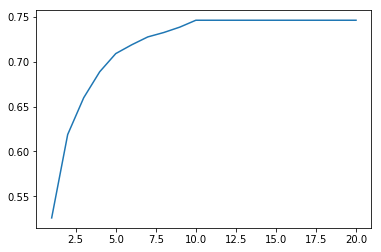

In [13]:
ks = list(range(1, 21))
accuracies = [evaluate.top_k_accuracy(valid_df['ja'].values, tr, k=k) for k in ks]
plt.plot(ks, accuracies)

In [14]:
print(evaluate.mrr(valid_df['ja'].values,
                   tr,
                   k=20))

0.6022360002781696
